<!-- ## HRV-Plus-Ultra : Mediapipe Face Landmarking

Overview: try to take a sample on each 30 sec interval, the first attempt shows possible noise on the main signal. Denoising the signal should be performed with investigation along with butter filter.

### Performance Comparison (30 sec length)
- Process with RunningMode.Video : 2:37 
- Process with RunningMode.Image : 2:43

Drawing the Facelandmark point is kinda useless in here, the result withtout drawing the landmark is around `1:43`

Well, the differences is kinda thin. The video utilizes something called `Temporal Information` which I guess doesn't fit too for my case, but let's stick to the Video one -->

## Reference Calculation on Feature Extraction
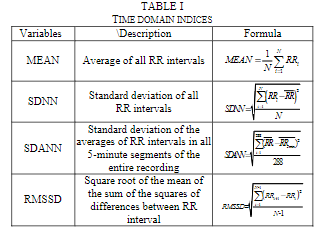

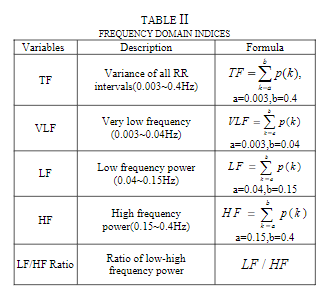

====================================================

### Using Frequency Domain for HRV Analysis
Reading duration should be a minimum of 5 minutes to be accurate. 2 minutes is for confidence in Low Frequency (LF) values. High frequency (HF) can reliably be measured in 60 seconds. You can start to measure LF in as little as 2 minutes, but research says 2 minutes+ is best for LF.

In theory, LF/HF shows ANS balance 

Low LF/HF ratio = PSNS dominance 

High LF/HF ratio = SNS dominance

### Ways to Calculate HRV
Link Ref: [ref](https://www.kubios.com/blog/hrv-analysis-methods/)

In [24]:
## Import Dependencies
import numpy as np
import mediapipe as mp
import pandas as pd
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.interpolate import interp1d
from scipy.fftpack import fft
from scipy import signal

In [25]:
## Ground Truth
ground_truth = pd.read_csv('../Samples/Original/bvp_s53_T3.csv', header=None).values.flatten() # 64 Hz

<!-- ---

## Resampling the Ground Truth to match with the Frame Video Frame Rate -->

In [26]:
# Target sampling rate for upsampling
upsample_rate = 100  # Hz

# Calculate the number of samples after upsampling
num_samples_upsampled = int(len(ground_truth) * (upsample_rate / 64))

# Upsample the ground truth data
upsampled_ground_truth = signal.resample(ground_truth, num_samples_upsampled)

# Create a new DataFrame for the upsampled data
# upsampled_ground_truth_df = pd.DataFrame(upsampled_ground_truth, columns=['BVP'])

# Show the upsampled ground truth length
print(f"Upsampled ground truth length: {len(upsampled_ground_truth)}")

Upsampled ground truth length: 18000


In [27]:
# ## Downsampling the ground truth to match on 35.14 Hz

# # Original ground truth sampling rate
# original_rate = 64.0  # Hz

# # Target sampling rate
# target_rate = 35  # Hz

# # Number sampling rate
# fs = 35

# # Calculate the number of samples after resampling
# num_samples = int(len(ground_truth) * (target_rate / original_rate))

# # Resample the ground truth data
# downsampled_ground_truth = signal.resample(ground_truth, num_samples)

# # Create a new DataFrame for the downsampled data
# downsampled_ground_truth_df = pd.DataFrame(downsampled_ground_truth, columns=['BVP'])

# ## Show the downsampled ground truth length
# print(f"Downsampled ground truth length: {len(downsampled_ground_truth)}")


<!-- ---

## Using POS (Plate Orthogonal to Skin) for the RPPG Technique to Estimate Heart Rate

[Ref. Paper](https://pure.tue.nl/ws/files/31563684/TBME_00467_2016_R1_preprint.pdf) -->

In [28]:
def preprocess_signal(rppg_signal, fs):
    # Narrower bandpass around expected heart rate frequencies (0.8-2.0 Hz)
    b, a = signal.butter(3, [0.8, 2.0], btype='band', fs=fs)
    filtered = signal.filtfilt(b, a, rppg_signal)
    
    # Additional lowpass to remove high-frequency noise
    b2, a2 = signal.butter(3, 2.5, btype='low', fs=fs)
    filtered = signal.filtfilt(b2, a2, filtered)
    
    # Moving average smoothing
    window = int(fs * 0.15)  # 150ms window
    smoothed = np.convolve(filtered, np.ones(window)/window, mode='same')
    
    return smoothed

<!-- --- 

## Working on Ground Truth Signal


The ground truth basically has been downsample to have 35 Hz -->

In [29]:
# ## Take the sample of the first 30 seconds with 35 frame rate of the ground truth
interval_duration = 30  # seconds
fs = 100 # 100 Hz

downsampled_ground_truth = upsampled_ground_truth[:1*interval_duration*fs]

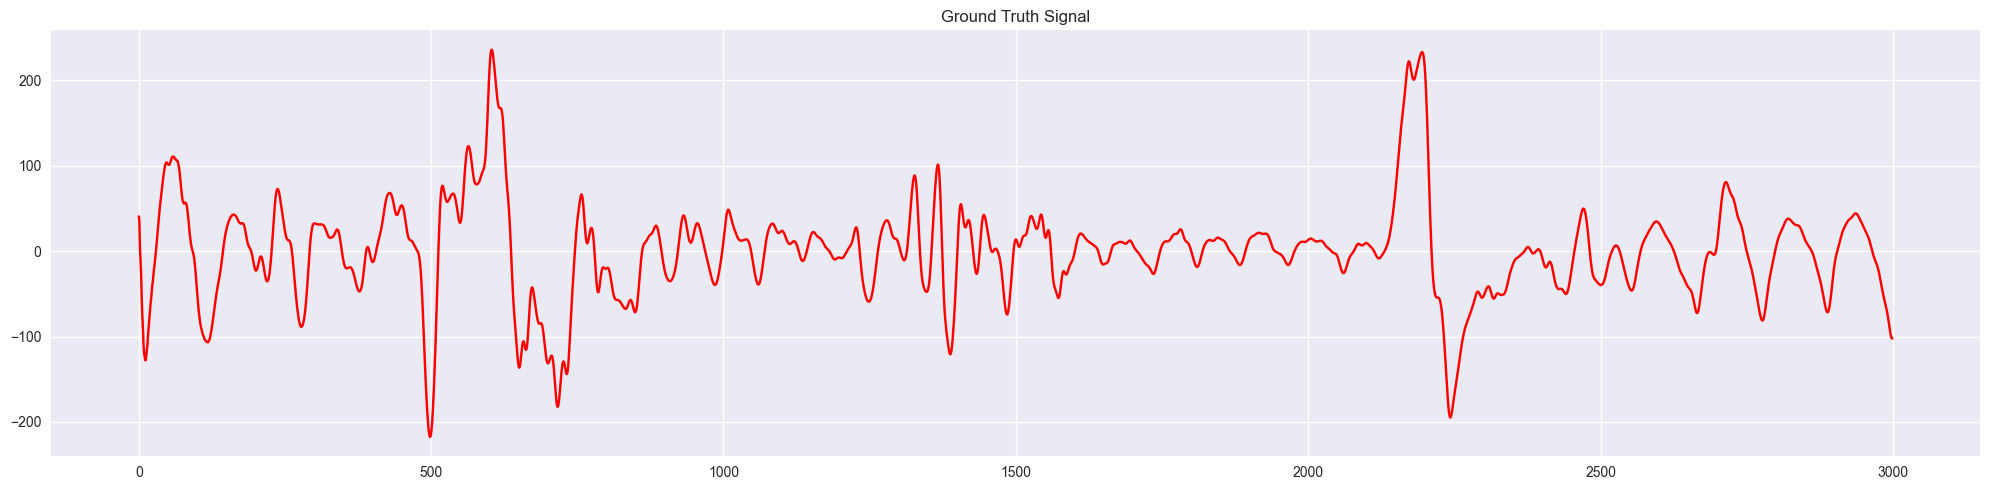

In [30]:
## Plot the Ground Truth
plt.figure(figsize=(20, 5)) 
plt.plot(downsampled_ground_truth, color='red')
plt.title('Ground Truth Signal')
plt.tight_layout()
plt.show()


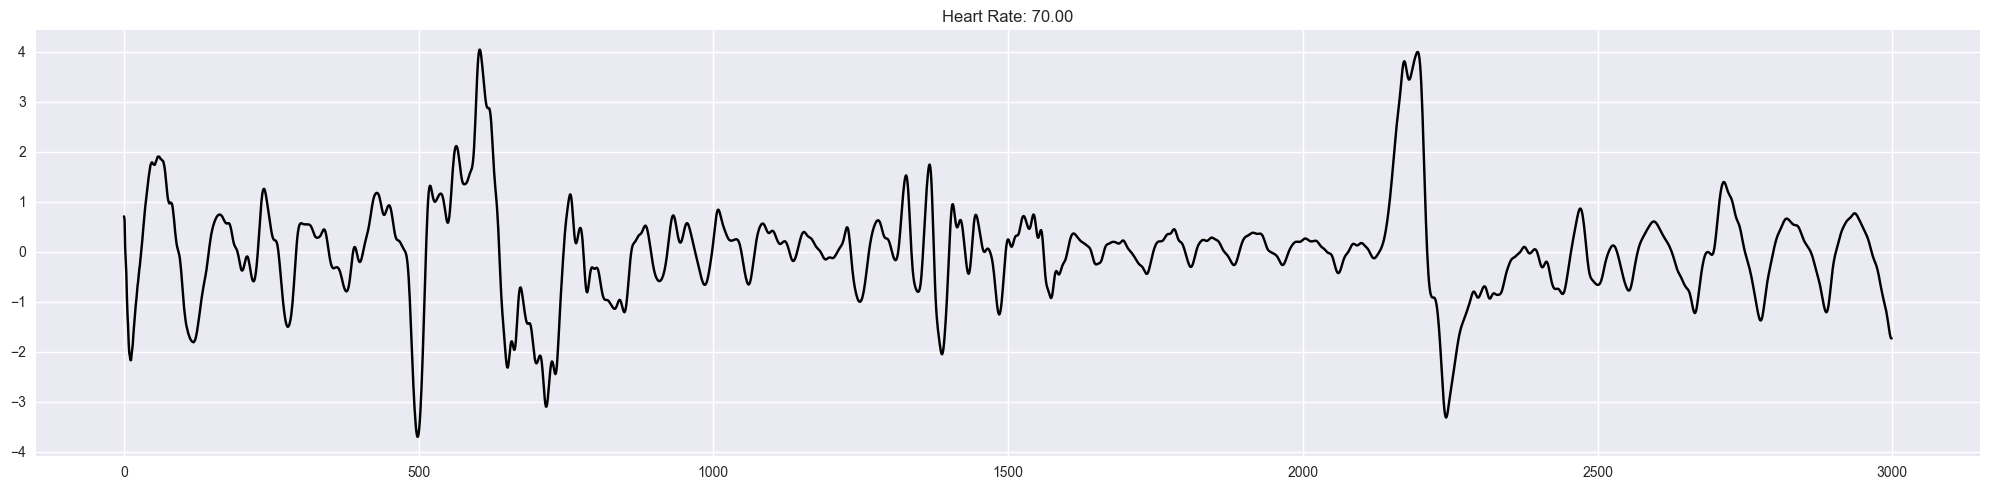

In [31]:
## Normalize the RPPG Signal
downsampled_ground_truth = (downsampled_ground_truth - np.mean(downsampled_ground_truth)) / np.std(downsampled_ground_truth)

## Finds Peak Signal
peaks, _ = signal.find_peaks(
    x=downsampled_ground_truth,
    prominence=0.5,
)

## Calculating the Heart Rate and Show the Result
heart_rate = 60 * len(peaks) / (len(downsampled_ground_truth) / fs)

plt.figure(figsize=(20, 5))
plt.plot(downsampled_ground_truth, color='black')
plt.plot(peaks, downsampled_ground_truth[peaks], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()

<!-- ### One Method, filter the Ground Truth -->

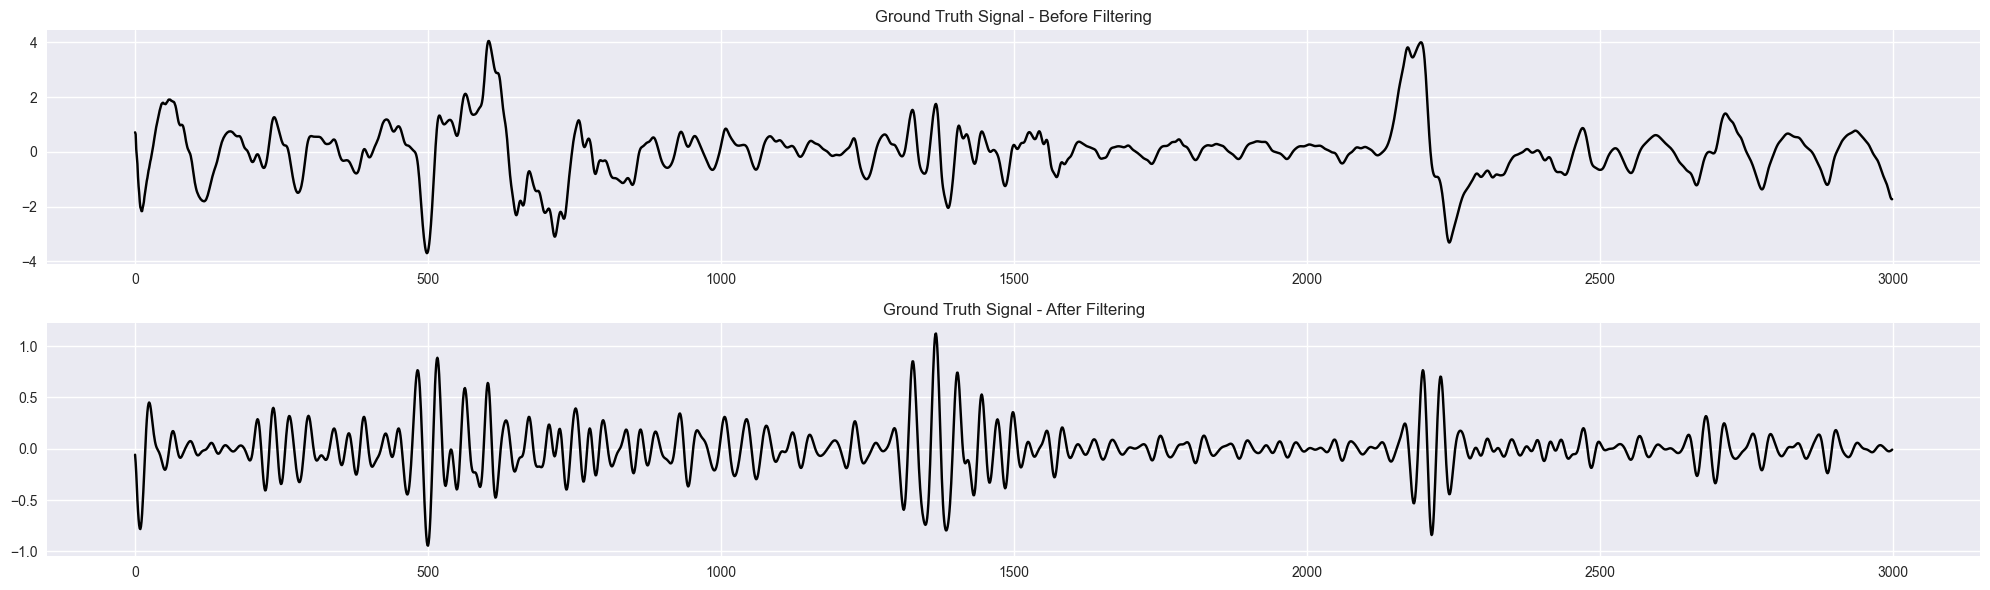

In [32]:
## Filter Original Length Signal
fs = 35; lowcut = 0.8; highcut = 2.9; order = 3
b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
# b, a = signal.butter(3, [0.8, 2.0], btype='band', fs=fs)
# downsamped_filtered = signal.filtfilt(b, a, downsampled_ground_truth)

# Additional lowpass to remove high-frequency noise
# b2, a2 = signal.butter(3, 2.5, btype='low', fs=fs)
# downsampled_ground_truth = signal.filtfilt(b2, a2, downsamped_filtered)

compressed_filtered_ground_truth = signal.filtfilt(b, a, downsampled_ground_truth)

compressed_filtered_ground_truth = preprocess_signal(downsampled_ground_truth, fs=35)

## Show the Filtered RPPG Signal
fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(downsampled_ground_truth, color='black')
ax[0].set_title('Ground Truth Signal - Before Filtering')
ax[1].plot(compressed_filtered_ground_truth, color='black')
ax[1].set_title('Ground Truth Signal - After Filtering')
plt.tight_layout()
plt.show()

<!-- ### Normalize and Finds Peak as the Heart Rate (QRS Complex) -->

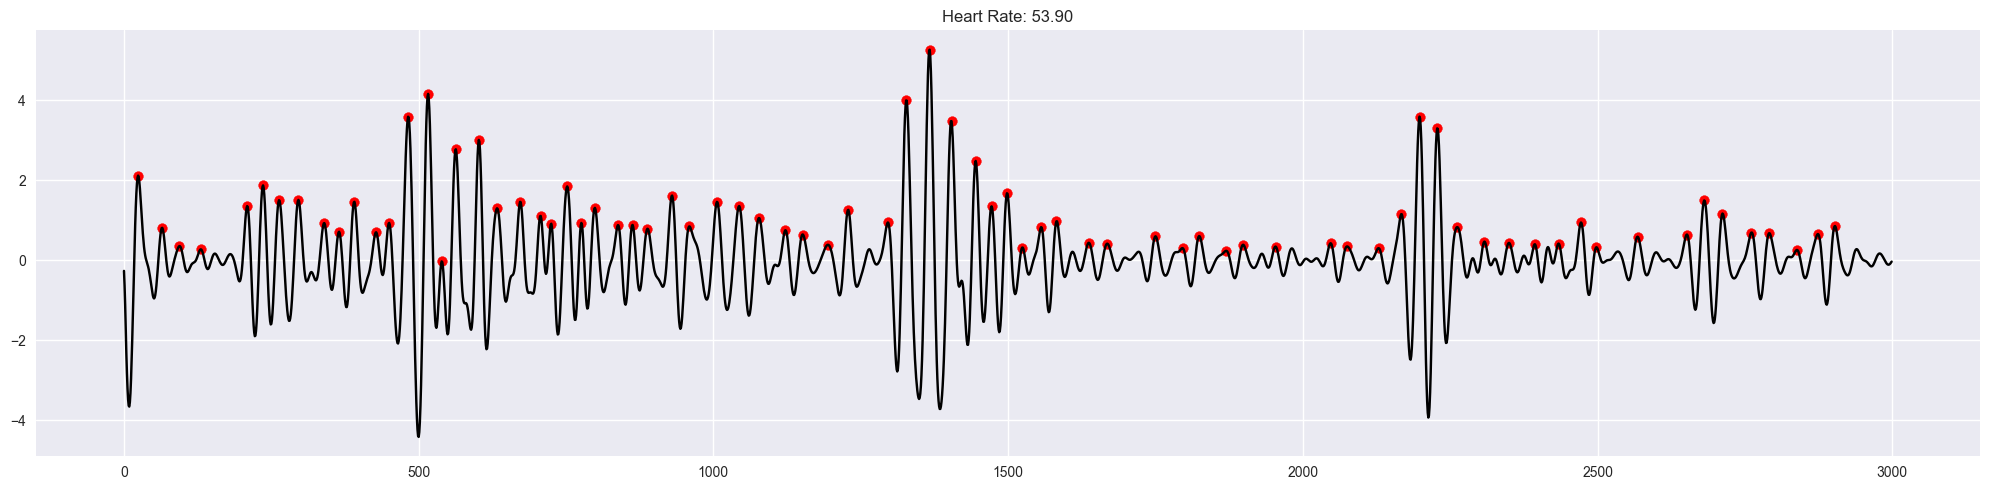

In [33]:
## Normalize the RPPG Signal
compressed_filtered_ground_truth = (compressed_filtered_ground_truth - np.mean(compressed_filtered_ground_truth)) / np.std(compressed_filtered_ground_truth)

## Finds Peak Signal
peaks_gt, _ = signal.find_peaks(
    x=compressed_filtered_ground_truth,
    prominence=0.5,
)

## Calculating the Heart Rate and Show the Result
heart_rate = 60 * len(peaks_gt) / (len(compressed_filtered_ground_truth) / fs)

## Plot the Ground Truth and its Peaks
plt.figure(figsize=(20, 5))
plt.plot(compressed_filtered_ground_truth, color='black')
plt.scatter(peaks_gt, compressed_filtered_ground_truth[peaks_gt], color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()


<!-- ---
Override Ground Truth and RPPG Signal are somehow not align, let's do the Frequency Analysis. -->

<!-- ---
Frequency Analysis on Both Signal -->

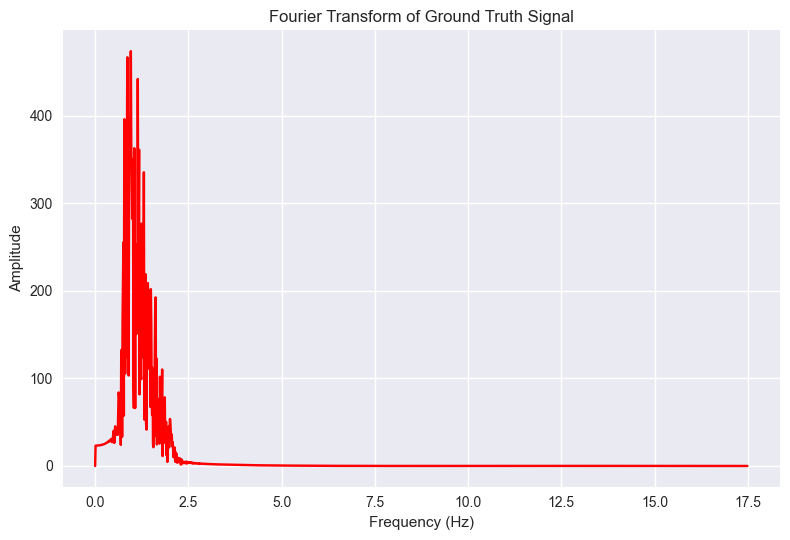

In [34]:
# Perform Fourier Transform on rPPG signal

# Perform Fourier Transform on ground truth signal
gt_freq = np.fft.fftfreq(len(compressed_filtered_ground_truth), d=1/fs)
gt_fft = np.fft.fft(compressed_filtered_ground_truth)

# Plot ground truth signal Fourier Transform
# plt.plot(gt_freq, np.abs(gt_fft), color='red')
plt.plot(gt_freq[:len(gt_freq)//2], np.abs(gt_fft)[:len(gt_fft)//2], color='red')
plt.title('Fourier Transform of Ground Truth Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

<!-- Calculating Dominant Freq -->

In [35]:
def dominant_frequency(signal, fs):
    freqs = np.fft.fftfreq(len(signal), d=1/fs)
    spectrum = np.abs(fft(signal))
    peak_freq = freqs[np.argmax(spectrum)]
    return peak_freq

ground_truth_freq = dominant_frequency(compressed_filtered_ground_truth, fs)

print(f"Ground Truth Frequency: {ground_truth_freq} Hz")

Ground Truth Frequency: 0.9566666666666667 Hz


Peaks: 65
RR Intervals: 64
Time-Domain Features: {'MeanNN': 1285.2678571428573, 'SDNN': 937.5186010059441, 'RMSSD': 1308.7728211481522, 'NN50': 56, 'pNN50': 87.5}
Frequency-Domain Features: {'VLF Power': 0.0, 'LF Power': 435634.4143478501, 'HF Power': 172738.6205163362, 'LF/HF Ratio': 2.5219282928489712, 'Total Power': 608373.0348641863}


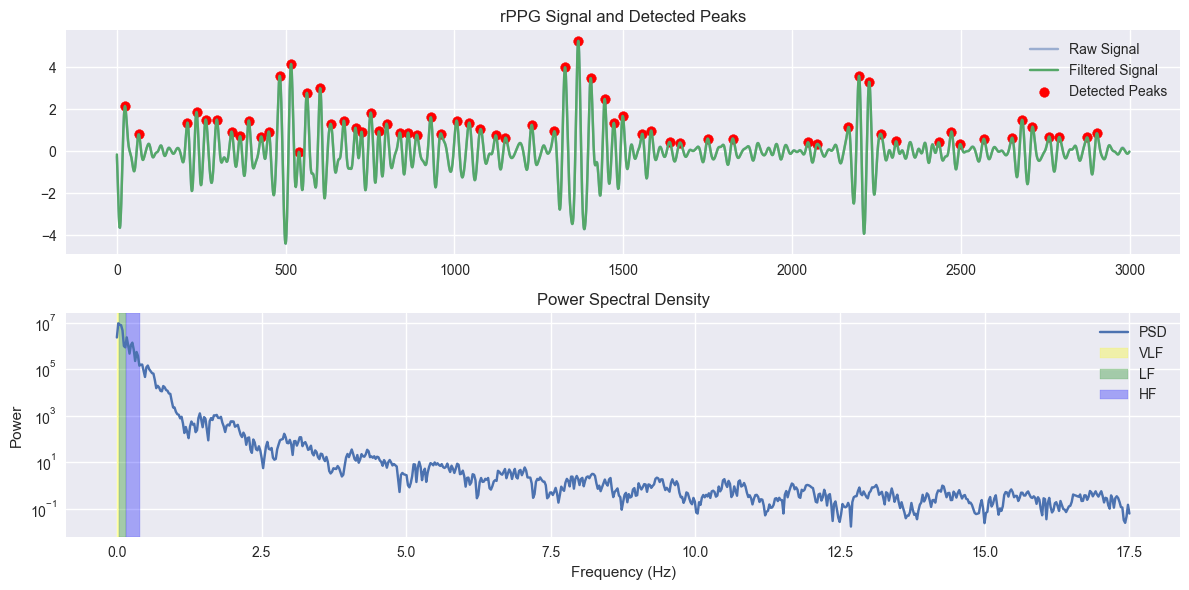

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from neurokit2 import hrv, rsp_simulate, signal_findpeaks

# Example rPPG signal (replace with real data)
# def generate_example_rppg():
#     signal = rsp_simulate(duration=60, sampling_rate=1000, respiratory_rate=15)
#     noise = np.random.normal(0, 0.01, len(signal))
#     return signal + noise

rppg_signal = compressed_filtered_ground_truth
sampling_rate = 35

# 1. Preprocessing
# Bandpass filter (0.5 - 4 Hz)
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

filtered_signal = bandpass_filter(rppg_signal, 0.5, 4, sampling_rate)

# 2. Peak Detection (RR intervals)
def detect_peaks(signal, fs):
    peaks = signal_findpeaks(signal, height_min=0.8)["Peaks"]
    rr_intervals = np.diff(peaks) / fs * 1000  # Convert to milliseconds
    return peaks, rr_intervals

peaks, rr_intervals = detect_peaks(filtered_signal, fs=sampling_rate)
## Print len of peaks and rr intervals
print(f"Peaks: {len(peaks)}")
print(f"RR Intervals: {len(rr_intervals)}")

# 3. Time-Domain Feature Extraction
def compute_time_domain_features(rr_intervals):
    mean_nn = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
    pnn50 = (nn50 / len(rr_intervals)) * 100
    return {
        "MeanNN": mean_nn,
        "SDNN": sdnn,
        "RMSSD": rmssd,
        "NN50": nn50,
        "pNN50": pnn50,
    }

time_features = compute_time_domain_features(rr_intervals)
print("Time-Domain Features:", time_features)

# 4. Frequency-Domain Feature Extraction
def compute_frequency_domain_features(rr_intervals, fs):
    # Interpolate RR intervals to create an evenly sampled signal
    rr_times = np.cumsum(rr_intervals) / 1000.0
    rr_interp = np.interp(
        np.arange(0, rr_times[-1], 1/fs), rr_times, rr_intervals
    )
    # Compute power spectral density
    f, psd = welch(rr_interp, fs=fs, nperseg=len(rr_interp)//2)
    vlf_band = (f >= 0.0033) & (f < 0.04)
    lf_band = (f >= 0.04) & (f < 0.15)
    hf_band = (f >= 0.15) & (f < 0.4)
    # Integrate PSD to get power in ms²
    vlf_power = np.trapz(psd[vlf_band], f[vlf_band]) 
    lf_power = np.trapz(psd[lf_band], f[lf_band]) 
    hf_power = np.trapz(psd[hf_band], f[hf_band]) 
    total_power = vlf_power + lf_power + hf_power
    lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.nan
    return {
        "VLF Power": vlf_power,
        "LF Power": lf_power,
        "HF Power": hf_power,
        "LF/HF Ratio": lf_hf_ratio,
        "Total Power": total_power,
    }, f, psd

freq_features, f, psd = compute_frequency_domain_features(rr_intervals, fs=sampling_rate)
print("Frequency-Domain Features:", freq_features)

# 5. Visualization
plt.figure(figsize=(12, 6))

# Raw and filtered signals
plt.subplot(2, 1, 1)
plt.plot(rppg_signal, label="Raw Signal", alpha=0.5)
plt.plot(filtered_signal, label="Filtered Signal")
plt.scatter(peaks, filtered_signal[peaks], color="red", label="Detected Peaks")
plt.title("rPPG Signal and Detected Peaks")
plt.legend()

# PSD
plt.subplot(2, 1, 2)
plt.semilogy(f, psd, label="PSD")
plt.axvspan(0.0033, 0.04, color="yellow", alpha=0.3, label="VLF")
plt.axvspan(0.04, 0.15, color="green", alpha=0.3, label="LF")
plt.axvspan(0.15, 0.4, color="blue", alpha=0.3, label="HF")
plt.title("Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()

plt.tight_layout()
plt.show()

### Feature Extraction

Based on the article, it seems we can take some features on the RPPG signal such as the SD, RMSSD, and other stuff. and do Some classification on the interval of 30 sec or so?

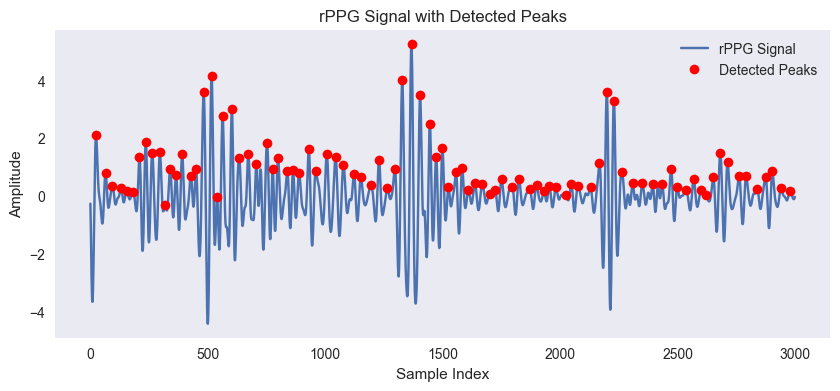

Detected RR Intervals (in ms): [1171.42857143  828.57142857 1028.57142857  685.71428571  742.85714286
  828.57142857  771.42857143  771.42857143  942.85714286  628.57142857
  628.57142857  714.28571429  742.85714286 1057.14285714  628.57142857
  914.28571429  971.42857143  657.14285714  685.71428571 1114.28571429
  885.71428571 1114.28571429 1000.         1285.71428571  685.71428571
  657.14285714 1114.28571429  714.28571429  714.28571429 1200.
  828.57142857 1342.85714286 1085.71428571  942.85714286 1285.71428571
  857.14285714 1200.         1000.         1000.          914.28571429
  885.71428571 1142.85714286 1057.14285714 1171.42857143  771.42857143
  742.85714286  742.85714286  914.28571429  742.85714286  771.42857143
  800.          885.71428571  885.71428571  628.57142857  828.57142857
 1314.28571429  800.         1314.28571429  828.57142857  914.28571429
  657.14285714  771.42857143 1200.          685.71428571  800.
 1542.85714286 1085.71428571  885.71428571  857.14285714  971.

In [37]:
# Example rPPG signal (replace with your actual rPPG signal)
fs = 35  # Sampling frequency in Hz

# Function to calculate RR intervals from rPPG signal
def calculate_rr_intervals(rppg_signal, fs):
    # Try adjusting the minimum distance between peaks based on expected heart rate
    distance = fs * 0.6  # e.g., for heart rate around 60 bpm, minimum 1-second distance
    peaks, _ = signal.find_peaks(rppg_signal, distance=distance)  # Adjust distance based on expected heart rate
    rr_intervals = np.diff(peaks) / fs * 1000  # Convert to milliseconds
    return peaks, rr_intervals  # Return both the peaks and the RR intervals for debugging

# Calculate RR intervals and peaks
peaks, rr_intervals = calculate_rr_intervals(compressed_filtered_ground_truth, fs)

# Visualize the rPPG signal and detected peaks
plt.figure(figsize=(10, 4))
plt.plot(compressed_filtered_ground_truth, label='rPPG Signal')
plt.plot(peaks, compressed_filtered_ground_truth[peaks], 'ro', label='Detected Peaks')
plt.title('rPPG Signal with Detected Peaks')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

# Print RR intervals for inspection
print("Detected RR Intervals (in ms):", rr_intervals)

## Print total RR Intervals
print(f"Total RR Intervals: {len(rr_intervals)}")


Total RR Intervals: 90
MeanNN: 938.10 ms, SDNN: 213.65 ms, RMSSD: 291.15 ms, NN50: 75, pNN50: 83.33%
LF: 0.003387583666836334 ms^2, HF: 5.9243879691293275e-05 ms^2, LF/HF Ratio: 57.18


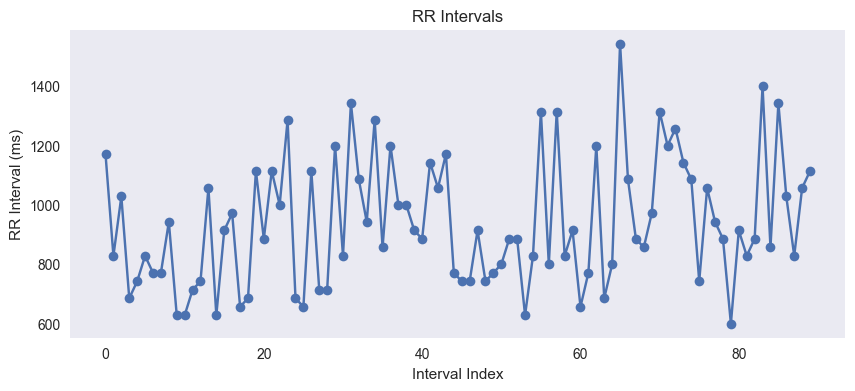

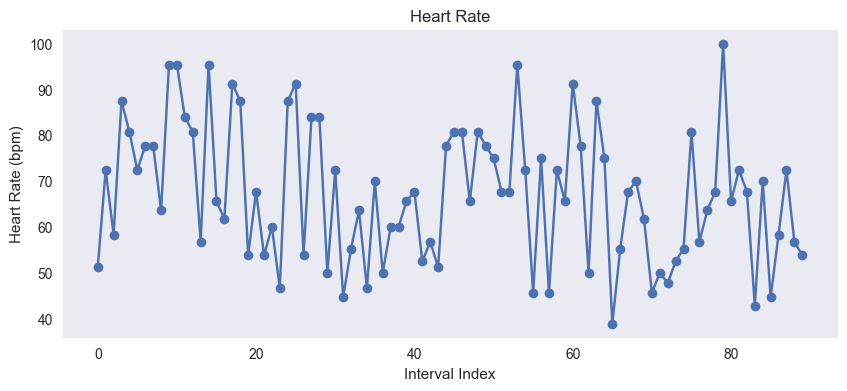

Stress Level: 2 (0: Low, 1-2: Moderate, 3-5: High)


In [38]:
fs = 35  # Sampling frequency in Hz

# Function to calculate time-domain features
def time_domain_features(rr_intervals):
    mean_nn = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
    pnn50 = nn50 / len(rr_intervals) * 100
    return mean_nn, sdnn, rmssd, nn50, pnn50

# Function to calculate frequency-domain features
def frequency_domain_features(rppg_signal, fs):

    f, pxx = signal.welch(rppg_signal, fs=fs)
    lf = np.sum(pxx[(f >= 0.04) & (f <= 0.15)])  # Low-frequency band (0.04-0.15 Hz)
    hf = np.sum(pxx[(f >= 0.15) & (f <= 0.4)])  # High-frequency band (0.15-0.4 Hz)
    lf_hf_ratio = lf / hf if hf > 0 else 0  # Prevent division by zero
    return lf, hf, lf_hf_ratio

# Function to calculate RR intervals from rPPG signal
def calculate_rr_intervals(rppg_signal, fs):
    peaks, _ = signal.find_peaks(rppg_signal, distance=fs*0.6)  # Adjust distance based on expected heart rate
    rr_intervals = np.diff(peaks) / fs * 1000  # Convert to milliseconds
    return rr_intervals

# Function to calculate heart rate from RR intervals
def calculate_heart_rate(rr_intervals):
    hr = 60000 / rr_intervals  # Convert RR intervals to heart rate in bpm
    return hr

# Calculate RR intervals
rr_intervals = calculate_rr_intervals(compressed_filtered_ground_truth, fs)
## Print total RR Intervals
print(f"Total RR Intervals: {len(rr_intervals)}")

# Calculate heart rate from RR intervals
heart_rate = calculate_heart_rate(rr_intervals)

# Calculate time-domain features
mean_nn, sdnn, rmssd, nn50, pnn50 = time_domain_features(rr_intervals)
print(f"MeanNN: {mean_nn:.2f} ms, SDNN: {sdnn:.2f} ms, RMSSD: {rmssd:.2f} ms, NN50: {nn50}, pNN50: {pnn50:.2f}%")

# Calculate frequency-domain features
lf, hf, lf_hf_ratio = frequency_domain_features(compressed_filtered_ground_truth, fs)
print(f"LF: {lf} ms^2, HF: {hf} ms^2, LF/HF Ratio: {lf_hf_ratio:.2f}")

# Plot RR intervals
plt.figure(figsize=(10, 4))
plt.plot(rr_intervals, marker='o')
plt.title('RR Intervals')
plt.xlabel('Interval Index')
plt.ylabel('RR Interval (ms)')
plt.grid()
plt.show()

# Plot heart rate
plt.figure(figsize=(10, 4))
plt.plot(heart_rate, marker='o')
plt.title('Heart Rate')
plt.xlabel('Interval Index')
plt.ylabel('Heart Rate (bpm)')
plt.grid()
plt.show()

# Mapping HRV features to stress
def map_hrv_to_stress(sdnn, rmssd, pnn50, lf, hf, lf_hf_ratio):
    stress_level = 0
    if sdnn < 50:
        stress_level += 1  # Lower SDNN indicates higher stress
    if rmssd < 30:
        stress_level += 1  # Lower RMSSD indicates higher stress
    if pnn50 < 20:
        stress_level += 1  # Lower pNN50 indicates higher stress
    if lf_hf_ratio > 2:
        stress_level += 1  # Higher LF/HF ratio indicates higher stress
    if hf < 100:
        stress_level += 1  # Lower HF indicates higher stress
    return stress_level

# Calculate stress level
stress_level = map_hrv_to_stress(sdnn, rmssd, pnn50, lf, hf, lf_hf_ratio)
print(f"Stress Level: {stress_level} (0: Low, 1-2: Moderate, 3-5: High)")

RMSSD: 5.92, SDNN: 4.06, LF/HF Ratio: 57.18
LF: 0.00, HF: 0.00
Stress Level: High Stress


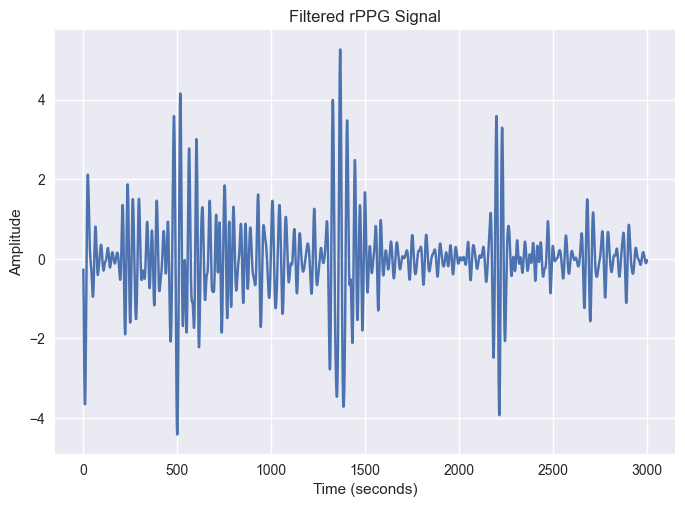

In [39]:
# Step 1: Preprocess the rPPG signal (Bandpass Filtering)
def preprocess_rppg(signal_data, fs=100):
    # Bandpass filter (0.5 Hz - 5 Hz to capture heart rate)
    nyquist = 0.5 * fs
    low = 0.5 / nyquist
    high = 5 / nyquist
    b, a = signal.butter(1, [low, high], btype='band')
    filtered_signal = signal.filtfilt(b, a, signal_data)
    return filtered_signal

# Step 2: Feature Extraction (Time-domain and Frequency-domain)
def extract_features(filtered_signal, fs=100):
    # Time-domain Features
    # RMSSD
    rr_intervals = np.diff(np.where(filtered_signal > np.mean(filtered_signal))[0])
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    
    # SDNN
    sdnn = np.std(rr_intervals)
    
    # Frequency-domain Features
    # Power Spectral Density using FFT
    freqs, psd = signal.welch(filtered_signal, fs)
    lf = np.sum(psd[(freqs >= 0.04) & (freqs <= 0.15)])  # Low-frequency band (0.04-0.15 Hz)
    hf = np.sum(psd[(freqs >= 0.15) & (freqs <= 0.4)])  # High-frequency band (0.15-0.4 Hz)
    lf_hf_ratio = lf / hf if hf > 0 else 0  # Prevent division by zero
    
    return rmssd, sdnn, lf_hf_ratio, hf, lf

# Step 3: Stress Detection (Mapping HRV Features to Stress Levels)
def stress_detection(rmssd, sdnn, lf_hf_ratio):
    # Define thresholds for HRV features
    stress_score = 0
    # RMSSD
    if rmssd > 20:
        stress_score += 0.1  # Low Stress
    elif rmssd <= 20 and rmssd >= 10:
        stress_score += 0.5  # Moderate Stress
    else:
        stress_score += 1  # High Stress
    
    # SDNN
    if sdnn > 50:
        stress_score += 0.1  # Low Stress
    elif sdnn <= 50 and sdnn >= 30:
        stress_score += 0.5  # Moderate Stress
    else:
        stress_score += 1  # High Stress
    
    # LF/HF Ratio
    if lf_hf_ratio < 1.5:
        stress_score += 0.1  # Low Stress
    elif lf_hf_ratio >= 1.5 and lf_hf_ratio <= 2.5:
        stress_score += 0.5  # Moderate Stress
    else:
        stress_score += 1  # High Stress
    
    # Mapping the final stress score to a stress level
    if stress_score < 0.5:
        return "Low Stress"
    elif stress_score < 1.5:
        return "Moderate Stress"
    else:
        return "High Stress"

# Example usage:
if __name__ == "__main__":
    # Simulate an rPPG signal (for demonstration purposes)
    # fs = 100  # Sampling frequency (Hz)
    # t = np.linspace(0, 60, fs * 60)  # 60 seconds of data
    # rppg_signal = np.sin(2 * np.pi * 1.0 * t) + 0.5 * np.random.randn(len(t))  # Simulated noisy rPPG signal
    
    # Preprocess the rPPG signal
    # filtered_rppg = preprocess_rppg(rppg_signal, fs)
    
    # Extract features
    rmssd, sdnn, lf_hf_ratio, hf, lf = extract_features(compressed_filtered_ground_truth, fs)
    
    # Print features
    print(f"RMSSD: {rmssd:.2f}, SDNN: {sdnn:.2f}, LF/HF Ratio: {lf_hf_ratio:.2f}")

    ## Print HF and LF
    print(f"LF: {lf:.2f}, HF: {hf:.2f}")
    
    # Detect stress level
    stress_level = stress_detection(rmssd, sdnn, lf_hf_ratio)
    print(f"Stress Level: {stress_level}")
    
    # Plot the filtered signal
    plt.plot(compressed_filtered_ground_truth)
    plt.title("Filtered rPPG Signal")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()


In [40]:
## Claude One

from scipy.interpolate import interp1d

def extract_hrv_features(rppg_signal, sampling_rate=35):
    """
    Extract HRV features from filtered rPPG signal in both time and frequency domains.
    
    Parameters:
    -----------
    rppg_signal : array-like
        The filtered rPPG signal
    sampling_rate : int
        Sampling rate of the signal in Hz (default: 35)
        
    Returns:
    --------
    dict
        Dictionary containing HRV features
    """
    # Find peaks (R-peaks equivalent in rPPG)
    peaks, _ = signal.find_peaks(rppg_signal, distance=sampling_rate//2)
    
    # Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(peaks) * (1000 / sampling_rate)
    
    # Remove outliers (basic cleaning)
    rr_cleaned = remove_outliers(rr_intervals)
    
    # Time domain features
    time_features = calculate_time_domain_features(rr_cleaned)
    print("Time: ", time_features)
    
    # Frequency domain features
    freq_features = calculate_frequency_domain_features(rr_cleaned, sampling_rate)
    print("Freq: ", freq_features)
    
    # Combine all features
    features = {**time_features, **freq_features}
    
    return features

def remove_outliers(rr_intervals, threshold=2.0):
    """
    Remove outliers from RR intervals using z-score method
    """
    z_scores = np.abs(signal.detrend(rr_intervals - np.mean(rr_intervals)) / np.std(rr_intervals))
    return rr_intervals[z_scores < threshold]

def calculate_time_domain_features(rr_intervals):
    """
    Calculate time domain HRV features
    """
    features = {}
    
    # Mean RR interval (AVNN)
    features['mean_rr'] = np.mean(rr_intervals)
    
    # Standard deviation of RR intervals (SDNN)
    features['sdnn'] = np.std(rr_intervals)
    
    # Root mean square of successive differences (RMSSD)
    rr_diff = np.diff(rr_intervals)
    features['rmssd'] = np.sqrt(np.mean(rr_diff ** 2))
    
    # Percentage of successive RR intervals differing by more than 50ms (pNN50)
    nn50 = sum(abs(rr_diff) > 50)
    features['pnn50'] = (nn50 / len(rr_diff)) * 100
    
    return features

def calculate_frequency_domain_features(rr_intervals, sampling_rate):
    """
    Calculate frequency domain HRV features
    """
    features = {}
    
    # Interpolate RR intervals to get evenly sampled signal
    time_points = np.cumsum(rr_intervals) / 1000  # Convert to seconds
    f = interp1d(time_points, rr_intervals, kind='cubic')
    
    # Create evenly sampled time points
    even_time_points = np.linspace(time_points[0], time_points[-1], len(rr_intervals))
    interpolated_rr = f(even_time_points)
    
    # Calculate power spectral density using Welch's method
    frequencies, psd = signal.welch(interpolated_rr, 
                                  fs=sampling_rate,
                                  nperseg=len(interpolated_rr)//2)
    
    # Define frequency bands
    vlf_mask = (frequencies >= 0.0033) & (frequencies < 0.04)  # Very low frequency
    lf_mask = (frequencies >= 0.04) & (frequencies < 0.15)    # Low frequency
    hf_mask = (frequencies >= 0.15) & (frequencies < 0.4)     # High frequency
    
    # Calculate power in each band
    features['vlf_power'] = np.trapz(psd[vlf_mask], frequencies[vlf_mask])
    features['lf_power'] = np.trapz(psd[lf_mask], frequencies[lf_mask])
    features['hf_power'] = np.trapz(psd[hf_mask], frequencies[hf_mask])
    
    # Calculate LF/HF ratio
    features['lf_hf_ratio'] = features['lf_power'] / features['hf_power']
    
    # Calculate total power
    features['total_power'] = features['vlf_power'] + features['lf_power'] + features['hf_power']
    
    # Calculate normalized powers
    features['lf_power_norm'] = features['lf_power'] / (features['lf_power'] + features['hf_power']) * 100
    features['hf_power_norm'] = features['hf_power'] / (features['lf_power'] + features['hf_power']) * 100
    
    return features

# Extract features
features = extract_hrv_features(downsampled_ground_truth, sampling_rate=35)

# Print results
for feature, value in features.items():
    print(f"{feature}: {value:.2f}")


Time:  {'mean_rr': 1166.4399092970523, 'sdnn': 572.4602859107233, 'rmssd': 806.3278377693636, 'pnn50': 93.54838709677419}
Freq:  {'vlf_power': 0.0, 'lf_power': 0.0, 'hf_power': 0.0, 'lf_hf_ratio': nan, 'total_power': 0.0, 'lf_power_norm': nan, 'hf_power_norm': nan}
mean_rr: 1166.44
sdnn: 572.46
rmssd: 806.33
pnn50: 93.55
vlf_power: 0.00
lf_power: 0.00
hf_power: 0.00
lf_hf_ratio: nan
total_power: 0.00
lf_power_norm: nan
hf_power_norm: nan


C:\Users\ACER\AppData\Local\Temp\ipykernel_12936\4202343076.py:102: RuntimeWarning: invalid value encountered in scalar divide
  features['lf_hf_ratio'] = features['lf_power'] / features['hf_power']
C:\Users\ACER\AppData\Local\Temp\ipykernel_12936\4202343076.py:108: RuntimeWarning: invalid value encountered in scalar divide
  features['lf_power_norm'] = features['lf_power'] / (features['lf_power'] + features['hf_power']) * 100
C:\Users\ACER\AppData\Local\Temp\ipykernel_12936\4202343076.py:109: RuntimeWarning: invalid value encountered in scalar divide
  features['hf_power_norm'] = features['hf_power'] / (features['lf_power'] + features['hf_power']) * 100


In [41]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d

def extract_hrv_features(rppg_signal, sampling_rate=35):
    """
    Extract HRV features from filtered rPPG signal in both time and frequency domains.
    
    Parameters:
    -----------
    rppg_signal : array-like
        The filtered rPPG signal
    sampling_rate : int
        Sampling rate of the signal in Hz (default: 30)
        
    Returns:
    --------
    dict
        Dictionary containing HRV features
    """
    # Find peaks (R-peaks equivalent in rPPG)
    peaks, _ = signal.find_peaks(rppg_signal, distance=sampling_rate//2)
    
    # Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(peaks) * (1000 / sampling_rate)
    
    # Remove outliers (basic cleaning)
    rr_cleaned = remove_outliers(rr_intervals)
    
    # Time domain features
    time_features = calculate_time_domain_features(rr_cleaned)
    
    # Frequency domain features
    freq_features = calculate_frequency_domain_features(rr_cleaned)
    
    # Combine all features
    features = {**time_features, **freq_features}
    
    return features

def remove_outliers(rr_intervals, threshold=2.0):
    """
    Remove outliers from RR intervals using z-score method
    """
    z_scores = np.abs(signal.detrend(rr_intervals - np.mean(rr_intervals)) / np.std(rr_intervals))
    return rr_intervals[z_scores < threshold]

def calculate_time_domain_features(rr_intervals):
    """
    Calculate time domain HRV features
    """
    features = {}
    
    # Mean RR interval (AVNN)
    features['mean_rr'] = np.mean(rr_intervals)
    
    # Standard deviation of RR intervals (SDNN)
    features['sdnn'] = np.std(rr_intervals)
    
    # Root mean square of successive differences (RMSSD)
    rr_diff = np.diff(rr_intervals)
    features['rmssd'] = np.sqrt(np.mean(rr_diff ** 2))
    
    # Percentage of successive RR intervals differing by more than 50ms (pNN50)
    nn50 = sum(abs(rr_diff) > 50)
    features['pnn50'] = (nn50 / len(rr_diff)) * 100
    
    return features

def calculate_frequency_domain_features(rr_intervals, resample_rate=4.0):
    """
    Calculate frequency domain HRV features using Lomb-Scargle periodogram
    
    Parameters:
    -----------
    rr_intervals : array-like
        RR intervals in milliseconds
    resample_rate : float
        Resampling rate in Hz for interpolation
    """
    features = {}
    
    # Convert RR intervals to time series
    rr_times = np.cumsum(rr_intervals) / 1000.0  # Convert to seconds
    rr_times = rr_times - rr_times[0]  # Start at zero
    
    # Remove trend using polynomial detrending
    rr_detrended = signal.detrend(rr_intervals, type='linear')
    
    # Create regular time array for interpolation
    regular_times = np.arange(0, rr_times[-1], 1/resample_rate)
    
    # Interpolate RR intervals
    f = interp1d(rr_times, rr_detrended, kind='linear', bounds_error=False, fill_value="extrapolate")
    interpolated_rr = f(regular_times)
    
    # Calculate Lomb-Scargle periodogram
    frequencies = np.linspace(0.01, 0.4, 1000)  # Frequency range of interest
    lombsc = signal.lombscargle(regular_times, interpolated_rr - np.mean(interpolated_rr), 
                              2*np.pi*frequencies, normalize=True)
    
    # Define frequency bands
    vlf_mask = (frequencies >= 0.0033) & (frequencies < 0.04)
    lf_mask = (frequencies >= 0.04) & (frequencies < 0.15)
    hf_mask = (frequencies >= 0.15) & (frequencies < 0.4)
    
    # Calculate power in each band (area under the curve)
    features['vlf_power'] = np.trapz(lombsc[vlf_mask], frequencies[vlf_mask])
    features['lf_power'] = np.trapz(lombsc[lf_mask], frequencies[lf_mask])
    features['hf_power'] = np.trapz(lombsc[hf_mask], frequencies[hf_mask])
    
    # Avoid division by zero
    total_power = features['vlf_power'] + features['lf_power'] + features['hf_power']
    features['total_power'] = total_power
    
    # Calculate LF/HF ratio and normalized powers with error handling
    if features['hf_power'] > 0:
        features['lf_hf_ratio'] = features['lf_power'] / features['hf_power']
    else:
        features['lf_hf_ratio'] = np.nan
        
    lf_hf_sum = features['lf_power'] + features['hf_power']
    if lf_hf_sum > 0:
        features['lf_power_norm'] = (features['lf_power'] / lf_hf_sum) * 100
        features['hf_power_norm'] = (features['hf_power'] / lf_hf_sum) * 100
    else:
        features['lf_power_norm'] = np.nan
        features['hf_power_norm'] = np.nan
    
    return features

# Example usage
if __name__ == "__main__":
    # Generate sample RR intervals (for demonstration)
    # np.random.seed(42)
    # sample_rr = np.random.normal(1000, 50, 100)  # Mean RR = 1000ms, SD = 50ms
    
    # Extract features
    features = extract_hrv_features(compressed_filtered_ground_truth)
    
    # Print results
    print("\nTime Domain Features:")
    for feature in ['mean_rr', 'sdnn', 'rmssd', 'pnn50']:
        print(f"{feature}: {features[feature]:.2f}")
        
    print("\nFrequency Domain Features:")
    for feature in ['vlf_power', 'lf_power', 'hf_power', 'lf_hf_ratio', 'total_power', 
                   'lf_power_norm', 'hf_power_norm']:
        print(f"{feature}: {features[feature]:.2f}")


Time Domain Features:
mean_rr: 809.52
sdnn: 184.00
rmssd: 232.30
pnn50: 78.95

Frequency Domain Features:
vlf_power: 0.00
lf_power: 0.00
hf_power: 0.01
lf_hf_ratio: 0.70
total_power: 0.01
lf_power_norm: 41.11
hf_power_norm: 58.89


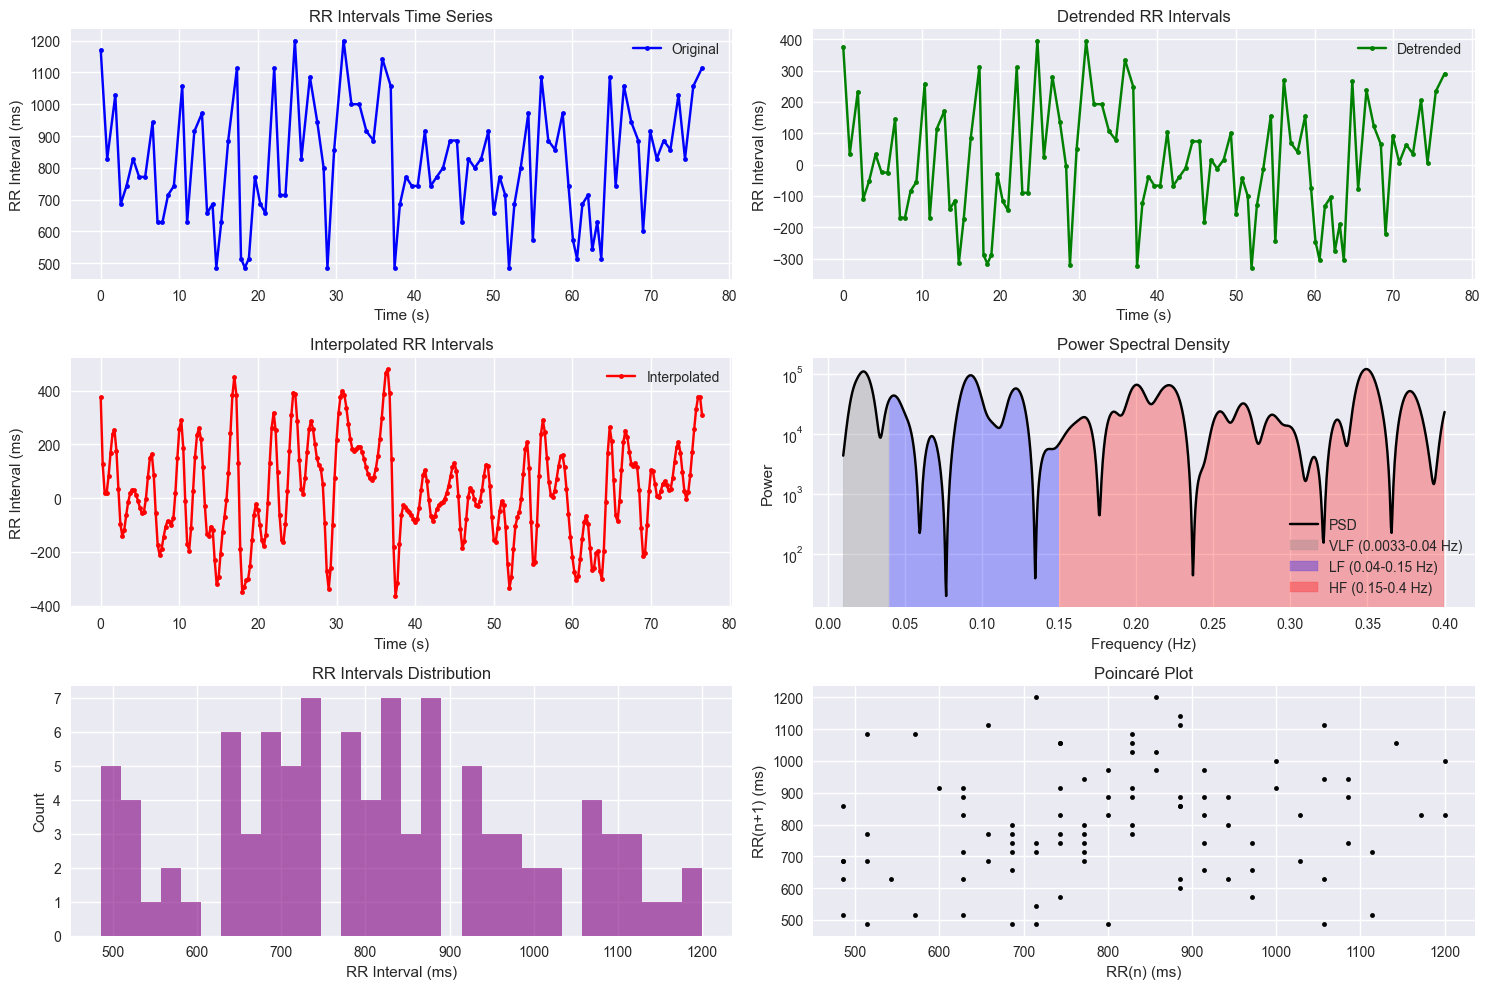


Time Domain Features:
mean_rr: 809.52
sdnn: 184.00
rmssd: 232.30
pnn50: 78.95

Frequency Domain Features:
vlf_power: 1507.50
lf_power: 2651.62
hf_power: 6103.27
lf_hf_ratio: 0.43
total_power: 10262.40
lf_power_norm: 30.29
hf_power_norm: 69.71


In [42]:
def extract_hrv_features(rppg_signal, sampling_rate=35, visualize=False):
    """
    Extract HRV features from filtered rPPG signal in both time and frequency domains.
    
    Parameters:
    -----------
    rppg_signal : array-like
        The filtered rPPG signal
    sampling_rate : int
        Sampling rate of the signal in Hz (default: 30)
    visualize : bool
        Whether to show visualization plots
        
    Returns:
    --------
    dict
        Dictionary containing HRV features
    """
    # Find peaks (R-peaks equivalent in rPPG)
    peaks, _ = signal.find_peaks(rppg_signal, distance=sampling_rate//2)
    
    # Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(peaks) * (1000 / sampling_rate)
    
    # Remove outliers (basic cleaning)
    rr_cleaned = remove_outliers(rr_intervals)
    
    # Time domain features
    time_features = calculate_time_domain_features(rr_cleaned)
    
    # Frequency domain features
    freq_features, freq_data = calculate_frequency_domain_features(rr_cleaned, return_plot_data=True)
    
    # Combine all features
    features = {**time_features, **freq_features}
    
    if visualize:
        plot_hrv_analysis(rr_cleaned, freq_data)
    
    return features

def remove_outliers(rr_intervals, threshold=2.0):
    """Remove outliers from RR intervals using z-score method"""
    z_scores = np.abs(signal.detrend(rr_intervals - np.mean(rr_intervals)) / np.std(rr_intervals))
    return rr_intervals[z_scores < threshold]

def calculate_time_domain_features(rr_intervals):
    """Calculate time domain HRV features"""
    features = {}
    
    features['mean_rr'] = np.mean(rr_intervals)
    features['sdnn'] = np.std(rr_intervals)
    
    rr_diff = np.diff(rr_intervals)
    features['rmssd'] = np.sqrt(np.mean(rr_diff ** 2))
    
    nn50 = sum(abs(rr_diff) > 50)
    features['pnn50'] = (nn50 / len(rr_diff)) * 100
    
    return features

def calculate_frequency_domain_features(rr_intervals, resample_rate=4.0, return_plot_data=False):
    """
    Calculate frequency domain HRV features using Lomb-Scargle periodogram
    """
    features = {}
    
    # Convert RR intervals to time series
    rr_times = np.cumsum(rr_intervals) / 1000.0  # Convert to seconds
    rr_times = rr_times - rr_times[0]  # Start at zero
    
    # Remove trend using polynomial detrending
    rr_detrended = signal.detrend(rr_intervals, type='linear')
    
    # Create regular time array for interpolation
    regular_times = np.arange(0, rr_times[-1], 1/resample_rate)
    
    # Interpolate RR intervals
    f = interp1d(rr_times, rr_detrended, kind='cubic', bounds_error=False, fill_value="extrapolate")
    interpolated_rr = f(regular_times)
    
    # Calculate Lomb-Scargle periodogram with increased amplitude scale
    frequencies = np.linspace(0.01, 0.4, 1000)  # Frequency range of interest
    power = signal.lombscargle(regular_times, 
                             interpolated_rr - np.mean(interpolated_rr), 
                             2*np.pi*frequencies, 
                             normalize=True)
    
    # Scale up the power values to avoid numerical precision issues
    power = power * 1e6  # Scale factor can be adjusted
    
    # Define frequency bands
    vlf_mask = (frequencies >= 0.0033) & (frequencies < 0.04)
    lf_mask = (frequencies >= 0.04) & (frequencies < 0.15)
    hf_mask = (frequencies >= 0.15) & (frequencies < 0.4)
    
    # Calculate power in each band (area under the curve)
    features['vlf_power'] = np.trapz(power[vlf_mask], frequencies[vlf_mask])
    features['lf_power'] = np.trapz(power[lf_mask], frequencies[lf_mask])
    features['hf_power'] = np.trapz(power[hf_mask], frequencies[hf_mask])
    
    # Calculate total power and ratios
    features['total_power'] = features['vlf_power'] + features['lf_power'] + features['hf_power']
    
    # Calculate LF/HF ratio and normalized powers
    lf_hf_sum = features['lf_power'] + features['hf_power']
    if lf_hf_sum > 0:
        features['lf_hf_ratio'] = features['lf_power'] / features['hf_power']
        features['lf_power_norm'] = (features['lf_power'] / lf_hf_sum) * 100
        features['hf_power_norm'] = (features['hf_power'] / lf_hf_sum) * 100
    else:
        features['lf_hf_ratio'] = np.nan
        features['lf_power_norm'] = np.nan
        features['hf_power_norm'] = np.nan

    if return_plot_data:
        plot_data = {
            'frequencies': frequencies,
            'power': power,
            'rr_times': rr_times,
            'rr_intervals': rr_intervals,
            'rr_detrended': rr_detrended,
            'interpolated_times': regular_times,
            'interpolated_rr': interpolated_rr
        }
        return features, plot_data
    
    return features

def plot_hrv_analysis(rr_intervals, freq_data):
    """
    Create comprehensive visualization of HRV analysis
    """
    plt.style.use("seaborn-v0_8")
    fig = plt.figure(figsize=(15, 10))
    
    # Plot 1: RR Intervals Time Series
    ax1 = plt.subplot(321)
    ax1.plot(freq_data['rr_times'], freq_data['rr_intervals'], 'b.-', label='Original')
    ax1.set_title('RR Intervals Time Series')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('RR Interval (ms)')
    ax1.legend()
    
    # Plot 2: Detrended RR Intervals
    ax2 = plt.subplot(322)
    ax2.plot(freq_data['rr_times'], freq_data['rr_detrended'], 'g.-', label='Detrended')
    ax2.set_title('Detrended RR Intervals')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('RR Interval (ms)')
    ax2.legend()
    
    # Plot 3: Interpolated RR Intervals
    ax3 = plt.subplot(323)
    ax3.plot(freq_data['interpolated_times'], freq_data['interpolated_rr'], 'r.-', label='Interpolated')
    ax3.set_title('Interpolated RR Intervals')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('RR Interval (ms)')
    ax3.legend()
    
    # Plot 4: Power Spectral Density
    ax4 = plt.subplot(324)
    ax4.plot(freq_data['frequencies'], freq_data['power'], 'k-', label='PSD')
    ax4.fill_between(freq_data['frequencies'][(freq_data['frequencies'] >= 0.0033) & (freq_data['frequencies'] < 0.04)],
                     freq_data['power'][(freq_data['frequencies'] >= 0.0033) & (freq_data['frequencies'] < 0.04)],
                     alpha=0.3, label='VLF (0.0033-0.04 Hz)', color='gray')
    ax4.fill_between(freq_data['frequencies'][(freq_data['frequencies'] >= 0.04) & (freq_data['frequencies'] < 0.15)],
                     freq_data['power'][(freq_data['frequencies'] >= 0.04) & (freq_data['frequencies'] < 0.15)],
                     alpha=0.3, label='LF (0.04-0.15 Hz)', color='blue')
    ax4.fill_between(freq_data['frequencies'][(freq_data['frequencies'] >= 0.15) & (freq_data['frequencies'] < 0.4)],
                     freq_data['power'][(freq_data['frequencies'] >= 0.15) & (freq_data['frequencies'] < 0.4)],
                     alpha=0.3, label='HF (0.15-0.4 Hz)', color='red')
    ax4.set_title('Power Spectral Density')
    ax4.set_xlabel('Frequency (Hz)')
    ax4.set_ylabel('Power')
    ax4.legend()
    ax4.set_yscale('log')  # Using log scale for better visualization
    
    # Plot 5: RR Intervals Histogram
    ax5 = plt.subplot(325)
    ax5.hist(rr_intervals, bins=30, color='purple', alpha=0.6)
    ax5.set_title('RR Intervals Distribution')
    ax5.set_xlabel('RR Interval (ms)')
    ax5.set_ylabel('Count')
    
    # Plot 6: Poincaré Plot
    ax6 = plt.subplot(326)
    ax6.plot(rr_intervals[:-1], rr_intervals[1:], 'k.')
    ax6.set_title('Poincaré Plot')
    ax6.set_xlabel('RR(n) (ms)')
    ax6.set_ylabel('RR(n+1) (ms)')
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate sample RR intervals (for demonstration)
    # np.random.seed(42)
    # sample_rr = np.random.normal(1000, 50, 100)  # Mean RR = 1000ms, SD = 50ms
    
    # Extract features with visualization
    features = extract_hrv_features(compressed_filtered_ground_truth, visualize=True)
    
    # Print results with better formatting
    print("\nTime Domain Features:")
    for feature in ['mean_rr', 'sdnn', 'rmssd', 'pnn50']:
        print(f"{feature}: {features[feature]:.2f}")
        
    print("\nFrequency Domain Features:")
    for feature in ['vlf_power', 'lf_power', 'hf_power', 'lf_hf_ratio', 'total_power', 
                   'lf_power_norm', 'hf_power_norm']:
        print(f"{feature}: {features[feature]:.2f}")

Total RR Intervals: 101


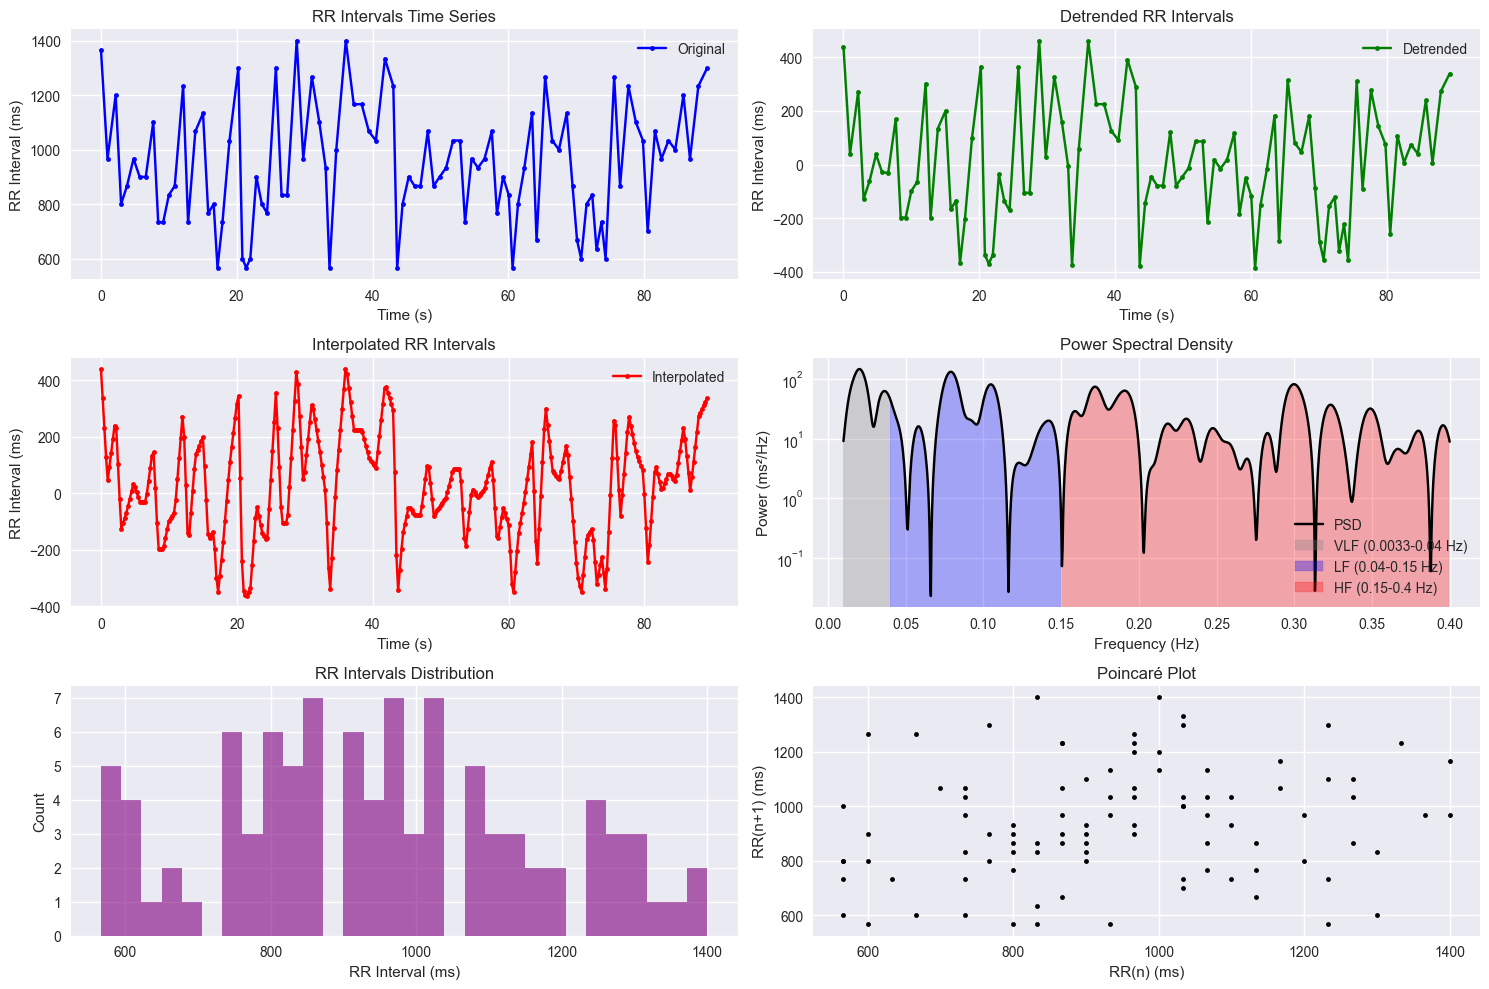


Time Domain Features:
Mean RR: 944.44 ms
SDNN: 214.66 ms
RMSSD: 271.02 ms
pNN50: 78.95%

Frequency Domain Features:
VLF Power: 2.04 ms²
LF Power: 3.06 ms²
HF Power: 4.89 ms²
Total Power: 9.98 ms²
LF/HF Ratio: 0.63

Normalized Units (n.u.):
LF Power: 38.51 n.u.
HF Power: 61.49 n.u.

Relative Powers (%):
VLF Power: 20.39%
LF Power: 30.66%
HF Power: 48.96%


In [43]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def extract_hrv_features(rppg_signal, sampling_rate=30, visualize=False):
    """
    Extract HRV features from filtered rPPG signal in both time and frequency domains.
    
    Parameters:
    -----------
    rppg_signal : array-like
        The filtered rPPG signal
    sampling_rate : int
        Sampling rate of the signal in Hz (default: 30)
    visualize : bool
        Whether to show visualization plots
        
    Returns:
    --------
    dict
        Dictionary containing HRV features
    """
    # Find peaks (R-peaks equivalent in rPPG)
    peaks, _ = signal.find_peaks(rppg_signal, distance=sampling_rate//2)
    
    # Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(peaks) * (1000 / sampling_rate)
    # rr_intervals = np.diff(peaks) / fs * 1000  # Convert to milliseconds
    ## Print RR intervals
    print(f"Total RR Intervals: {len(rr_intervals)}")
    
    # Remove outliers (basic cleaning)
    rr_cleaned = remove_outliers(rr_intervals)
    
    # Time domain features
    time_features = calculate_time_domain_features(rr_cleaned)
    
    # Frequency domain features
    freq_features, freq_data = calculate_frequency_domain_features(rr_cleaned, return_plot_data=True)
    
    # Combine all features
    features = {**time_features, **freq_features}
    
    if visualize:
        plot_hrv_analysis(rr_cleaned, freq_data)
    
    return features

def remove_outliers(rr_intervals, threshold=2.0):
    """Remove outliers from RR intervals using z-score method"""
    z_scores = np.abs(signal.detrend(rr_intervals - np.mean(rr_intervals)) / np.std(rr_intervals))
    return rr_intervals[z_scores < threshold]

def calculate_time_domain_features(rr_intervals):
    """Calculate time domain HRV features"""
    features = {}
    
    features['mean_rr'] = np.mean(rr_intervals)
    features['sdnn'] = np.std(rr_intervals)
    
    rr_diff = np.diff(rr_intervals)
    features['rmssd'] = np.sqrt(np.mean(rr_diff ** 2))
    
    nn50 = sum(abs(rr_diff) > 50)
    features['pnn50'] = (nn50 / len(rr_diff)) * 100
    
    return features

def calculate_frequency_domain_features(rr_intervals, resample_rate=4.0, return_plot_data=False):
    """
    Calculate frequency domain HRV features using Lomb-Scargle periodogram with adjusted scaling
    """
    features = {}
    
    # Convert RR intervals to time series
    rr_times = np.cumsum(rr_intervals) / 1000.0  # Convert to seconds
    rr_times = rr_times - rr_times[0]  # Start at zero
    
    # Remove trend using polynomial detrending
    rr_detrended = signal.detrend(rr_intervals, type='linear')
    
    # Create regular time array for interpolation
    regular_times = np.arange(0, rr_times[-1], 1/resample_rate)
    
    # Interpolate RR intervals
    f = interp1d(rr_times, rr_detrended, kind='linear', bounds_error=False, fill_value="extrapolate")
    interpolated_rr = f(regular_times)
    
    # Calculate Lomb-Scargle periodogram
    frequencies = np.linspace(0.01, 0.4, 1000)
    power = signal.lombscargle(regular_times, 
                             interpolated_rr - np.mean(interpolated_rr), 
                             2*np.pi*frequencies, 
                             normalize=True)
    
    # Apply scaling factor (adjusted to get more standard ranges)
    power = power * 1e3  # Reduced scaling factor
    
    # Define frequency bands
    vlf_mask = (frequencies >= 0.0033) & (frequencies < 0.04)
    lf_mask = (frequencies >= 0.04) & (frequencies < 0.15)
    hf_mask = (frequencies >= 0.15) & (frequencies < 0.4)
    
    # Calculate absolute powers
    vlf_power = np.trapz(power[vlf_mask], frequencies[vlf_mask])
    lf_power = np.trapz(power[lf_mask], frequencies[lf_mask])
    hf_power = np.trapz(power[hf_mask], frequencies[hf_mask])
    total_power = vlf_power + lf_power + hf_power
    
    # Store absolute powers in ms²
    features['vlf_power'] = vlf_power
    features['lf_power'] = lf_power
    features['hf_power'] = hf_power
    features['total_power'] = total_power
    
    # Calculate normalized powers (in normalized units, n.u.)
    lf_hf_sum = lf_power + hf_power
    if lf_hf_sum > 0:
        features['lf_hf_ratio'] = lf_power / hf_power
        features['lf_power_nu'] = (lf_power / lf_hf_sum) * 100
        features['hf_power_nu'] = (hf_power / lf_hf_sum) * 100
    else:
        features['lf_hf_ratio'] = np.nan
        features['lf_power_nu'] = np.nan
        features['hf_power_nu'] = np.nan
    
    # Calculate relative powers (as percentage of total power)
    if total_power > 0:
        features['vlf_power_rel'] = (vlf_power / total_power) * 100
        features['lf_power_rel'] = (lf_power / total_power) * 100
        features['hf_power_rel'] = (hf_power / total_power) * 100
    else:
        features['vlf_power_rel'] = np.nan
        features['lf_power_rel'] = np.nan
        features['hf_power_rel'] = np.nan

    if return_plot_data:
        plot_data = {
            'frequencies': frequencies,
            'power': power,
            'rr_times': rr_times,
            'rr_intervals': rr_intervals,
            'rr_detrended': rr_detrended,
            'interpolated_times': regular_times,
            'interpolated_rr': interpolated_rr
        }
        return features, plot_data
    
    return features

def plot_hrv_analysis(rr_intervals, freq_data):
    """Create comprehensive visualization of HRV analysis"""
    plt.style.use("seaborn-v0_8")
    fig = plt.figure(figsize=(15, 10))
    
    # Plot 1: RR Intervals Time Series
    ax1 = plt.subplot(321)
    ax1.plot(freq_data['rr_times'], freq_data['rr_intervals'], 'b.-', label='Original')
    ax1.set_title('RR Intervals Time Series')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('RR Interval (ms)')
    ax1.legend()
    
    # Plot 2: Detrended RR Intervals
    ax2 = plt.subplot(322)
    ax2.plot(freq_data['rr_times'], freq_data['rr_detrended'], 'g.-', label='Detrended')
    ax2.set_title('Detrended RR Intervals')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('RR Interval (ms)')
    ax2.legend()
    
    # Plot 3: Interpolated RR Intervals
    ax3 = plt.subplot(323)
    ax3.plot(freq_data['interpolated_times'], freq_data['interpolated_rr'], 'r.-', label='Interpolated')
    ax3.set_title('Interpolated RR Intervals')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('RR Interval (ms)')
    ax3.legend()
    
    # Plot 4: Power Spectral Density
    ax4 = plt.subplot(324)
    ax4.plot(freq_data['frequencies'], freq_data['power'], 'k-', label='PSD')
    ax4.fill_between(freq_data['frequencies'][(freq_data['frequencies'] >= 0.0033) & (freq_data['frequencies'] < 0.04)],
                     freq_data['power'][(freq_data['frequencies'] >= 0.0033) & (freq_data['frequencies'] < 0.04)],
                     alpha=0.3, label='VLF (0.0033-0.04 Hz)', color='gray')
    ax4.fill_between(freq_data['frequencies'][(freq_data['frequencies'] >= 0.04) & (freq_data['frequencies'] < 0.15)],
                     freq_data['power'][(freq_data['frequencies'] >= 0.04) & (freq_data['frequencies'] < 0.15)],
                     alpha=0.3, label='LF (0.04-0.15 Hz)', color='blue')
    ax4.fill_between(freq_data['frequencies'][(freq_data['frequencies'] >= 0.15) & (freq_data['frequencies'] < 0.4)],
                     freq_data['power'][(freq_data['frequencies'] >= 0.15) & (freq_data['frequencies'] < 0.4)],
                     alpha=0.3, label='HF (0.15-0.4 Hz)', color='red')
    ax4.set_title('Power Spectral Density')
    ax4.set_xlabel('Frequency (Hz)')
    ax4.set_ylabel('Power (ms²/Hz)')
    ax4.legend()
    ax4.set_yscale('log')
    
    # Plot 5: RR Intervals Histogram
    ax5 = plt.subplot(325)
    ax5.hist(rr_intervals, bins=30, color='purple', alpha=0.6)
    ax5.set_title('RR Intervals Distribution')
    ax5.set_xlabel('RR Interval (ms)')
    ax5.set_ylabel('Count')
    
    # Plot 6: Poincaré Plot
    ax6 = plt.subplot(326)
    ax6.plot(rr_intervals[:-1], rr_intervals[1:], 'k.')
    ax6.set_title('Poincaré Plot')
    ax6.set_xlabel('RR(n) (ms)')
    ax6.set_ylabel('RR(n+1) (ms)')
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # np.random.seed(42)
    # sample_rr = np.random.normal(1000, 50, 100)
    
    features = extract_hrv_features(compressed_filtered_ground_truth, visualize=True)
    
    print("\nTime Domain Features:")
    print(f"Mean RR: {features['mean_rr']:.2f} ms")
    print(f"SDNN: {features['sdnn']:.2f} ms")
    print(f"RMSSD: {features['rmssd']:.2f} ms")
    print(f"pNN50: {features['pnn50']:.2f}%")
    
    print("\nFrequency Domain Features:")
    print(f"VLF Power: {features['vlf_power']:.2f} ms²")
    print(f"LF Power: {features['lf_power']:.2f} ms²")
    print(f"HF Power: {features['hf_power']:.2f} ms²")
    print(f"Total Power: {features['total_power']:.2f} ms²")
    print(f"LF/HF Ratio: {features['lf_hf_ratio']:.2f}")
    
    print("\nNormalized Units (n.u.):")
    print(f"LF Power: {features['lf_power_nu']:.2f} n.u.")
    print(f"HF Power: {features['hf_power_nu']:.2f} n.u.")
    
    print("\nRelative Powers (%):")
    print(f"VLF Power: {features['vlf_power_rel']:.2f}%")
    print(f"LF Power: {features['lf_power_rel']:.2f}%")
    print(f"HF Power: {features['hf_power_rel']:.2f}%")

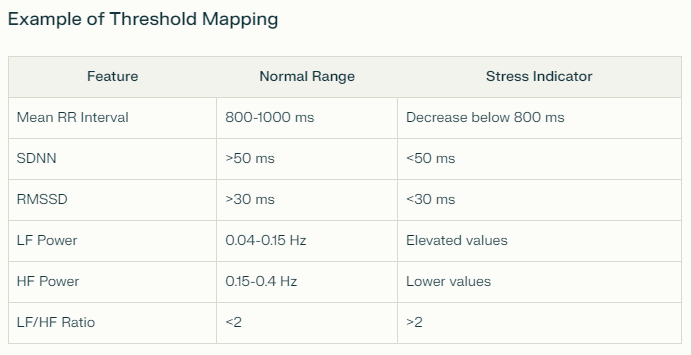

In [44]:
import numpy as np

class StressDetector:
    """
    A rule-based stress detection system using HRV features.
    
    This class implements stress detection using both time and frequency domain HRV features.
    The rules are based on established physiological thresholds from HRV research literature.
    Stress is typically associated with:
    - Decreased SDNN (reduced overall variability)
    - Decreased RMSSD (reduced short-term variability)
    - Decreased pNN50 (reduced parasympathetic activity)
    - Increased LF/HF ratio (sympathetic dominance)
    - Decreased HF power (reduced parasympathetic activity)
    """
    
    def __init__(self):
        # Define thresholds for various HRV parameters
        # These thresholds are based on literature values for normal vs stressed states
        self.thresholds = {
            'sdnn': {
                'low_stress': 50,    # ms: Higher values indicate relaxed state
                'high_stress': 30    # ms: Lower values indicate stress
            },
            'rmssd': {
                'low_stress': 30,    # ms: Higher values indicate relaxed state
                'high_stress': 20    # ms: Lower values indicate stress
            },
            'pnn50': {
                'low_stress': 40,    # %: Higher values indicate relaxed state
                'high_stress': 20    # %: Lower values indicate stress
            },
            'lf_hf_ratio': {
                'low_stress': 2.0,   # Lower values indicate relaxed state
                'high_stress': 3.0   # Higher values indicate stress
            },
            'hf_power_nu': {
                'low_stress': 40,    # n.u.: Higher values indicate relaxed state
                'high_stress': 20    # n.u.: Lower values indicate stress
            }
        }
    
    def detect_stress(self, features):
        """
        Detect stress levels based on HRV features.
        
        Parameters:
        -----------
        features : dict
            Dictionary containing HRV features from time and frequency domains
            
        Returns:
        --------
        dict
            Dictionary containing stress assessment results
        """
        # Initialize stress scores for different parameters
        stress_scores = {}
        
        # Evaluate SDNN (Standard deviation of NN intervals)
        stress_scores['sdnn'] = self._evaluate_parameter(
            features['sdnn'],
            self.thresholds['sdnn']['high_stress'],
            self.thresholds['sdnn']['low_stress'],
            inverse=True
        )
        
        # Evaluate RMSSD (Root mean square of successive differences)
        stress_scores['rmssd'] = self._evaluate_parameter(
            features['rmssd'],
            self.thresholds['rmssd']['high_stress'],
            self.thresholds['rmssd']['low_stress'],
            inverse=True
        )
        
        # Evaluate pNN50 (Percentage of successive NN intervals differing by > 50ms)
        stress_scores['pnn50'] = self._evaluate_parameter(
            features['pnn50'],
            self.thresholds['pnn50']['high_stress'],
            self.thresholds['pnn50']['low_stress'],
            inverse=True
        )
        
        # Evaluate LF/HF ratio
        stress_scores['lf_hf_ratio'] = self._evaluate_parameter(
            features['lf_hf_ratio'],
            self.thresholds['lf_hf_ratio']['low_stress'],
            self.thresholds['lf_hf_ratio']['high_stress'],
            inverse=True
        )
        
        # Evaluate normalized HF power
        stress_scores['hf_power'] = self._evaluate_parameter(
            features['hf_power_nu'],
            self.thresholds['hf_power_nu']['high_stress'],
            self.thresholds['hf_power_nu']['low_stress'],
            inverse=False
        )
        
        # Calculate overall stress score (weighted average)
        weights = {
            'sdnn': 0.2,
            'rmssd': 0.2,
            'pnn50': 0.2,
            'lf_hf_ratio': 0.2,
            'hf_power': 0.2
        }
        
        overall_score = sum(stress_scores[param] * weights[param] 
                          for param in stress_scores.keys())
        
        # Determine stress level category
        stress_level = self._categorize_stress(overall_score)
        
        # Prepare detailed analysis
        analysis = {
            'overall_stress_score': overall_score,
            'stress_level': stress_level,
            'parameter_scores': stress_scores,
            'interpretation': self._generate_interpretation(stress_scores, overall_score)
        }
        
        return analysis
    
    def _evaluate_parameter(self, value, high_stress_threshold, low_stress_threshold, inverse=False):
        """
        Evaluate a single parameter and return a stress score between 0 and 1.
        0 indicates no stress, 1 indicates high stress.
        
        The 'inverse' parameter handles cases where higher values indicate less stress
        (like SDNN, RMSSD) vs cases where higher values indicate more stress (like LF/HF ratio).
        """
        if inverse:
            # For parameters where higher values indicate less stress
            if value >= low_stress_threshold:
                return 0.0
            elif value <= high_stress_threshold:
                return 1.0
            else:
                # Linear interpolation between thresholds
                return (low_stress_threshold - value) / (low_stress_threshold - high_stress_threshold)
        else:
            # For parameters where higher values indicate more stress
            if value <= low_stress_threshold:
                return 0.0
            elif value >= high_stress_threshold:
                return 1.0
            else:
                # Linear interpolation between thresholds
                return (value - low_stress_threshold) / (high_stress_threshold - low_stress_threshold)
    
    def _categorize_stress(self, score):
        """
        Categorize the stress level based on the overall score.
        """
        if score < 0.3:
            return "Low stress - Relaxed state"
        elif score < 0.6:
            return "Moderate stress"
        else:
            return "High stress"
    
    def _generate_interpretation(self, scores, overall_score):
        """
        Generate a detailed interpretation of the stress analysis.
        """
        interpretations = []
        
        # Add overall stress level interpretation
        interpretations.append(f"Overall stress level: {self._categorize_stress(overall_score)}")
        interpretations.append(f"Overall stress score: {overall_score:.2f} (0-1 scale)")
        
        # Add specific parameter interpretations
        param_names = {
            'sdnn': 'Overall heart rate variability (SDNN)',
            'rmssd': 'Short-term variability (RMSSD)',
            'pnn50': 'Beat-to-beat variability (pNN50)',
            'lf_hf_ratio': 'Autonomic balance (LF/HF ratio)',
            'hf_power': 'Parasympathetic activity (HF power)'
        }
        
        for param, score in scores.items():
            status = "high" if score > 0.6 else "moderate" if score > 0.3 else "low"
            interpretations.append(f"{param_names[param]}: {status} stress indication (score: {score:.2f})")
        
        return "\n".join(interpretations)

# Example usage
if __name__ == "__main__":
    # Create sample HRV features
    sample_features = {
        'sdnn': 45,
        'rmssd': 25,
        'pnn50': 30,
        'lf_hf_ratio': 2.5,
        'hf_power_nu': 30
    }
    
    # Create stress detector and analyze
    detector = StressDetector() 
    print(features)
    stress_analysis = detector.detect_stress(features)
    
    # Print results
    print("\nStress Analysis Results:")
    print("------------------------")
    print(stress_analysis['interpretation'])

{'mean_rr': 944.4444444444447, 'sdnn': 214.663100959574, 'rmssd': 271.01714410284234, 'pnn50': 78.94736842105263, 'vlf_power': 2.0352422980985807, 'lf_power': 3.060736337981143, 'hf_power': 4.887459220873912, 'total_power': 9.983437856953636, 'lf_hf_ratio': 0.6262428390008873, 'lf_power_nu': 38.50856858411326, 'hf_power_nu': 61.491431415886744, 'vlf_power_rel': 20.386186875305683, 'lf_power_rel': 30.658139829550674, 'hf_power_rel': 48.95567329514364}

Stress Analysis Results:
------------------------
Overall stress level: Moderate stress
Overall stress score: 0.40 (0-1 scale)
Overall heart rate variability (SDNN): low stress indication (score: 0.00)
Short-term variability (RMSSD): low stress indication (score: 0.00)
Beat-to-beat variability (pNN50): low stress indication (score: 0.00)
Autonomic balance (LF/HF ratio): high stress indication (score: 1.00)
Parasympathetic activity (HF power): high stress indication (score: 1.00)


---------------
### WIP

In [45]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

class StressDetector:
    """
    Detect stress levels using HRV features from both time and frequency domains.
    Uses a Random Forest classifier to categorize stress levels.
    """
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        
    def extract_stress_features(self, hrv_features):
        """
        Extract relevant features for stress detection from HRV measurements.
        
        Parameters:
        -----------
        hrv_features : dict
            Dictionary containing HRV features from time and frequency domains
            
        Returns:
        --------
        numpy.ndarray
            Array of selected features for stress detection
        """
        # Select features known to be sensitive to stress
        selected_features = [
            # Time domain features
            hrv_features['sdnn'],          # Overall HRV (↓ during stress)
            hrv_features['rmssd'],         # Short-term HRV (↓ during stress)
            hrv_features['pnn50'],         # Parasympathetic activity (↓ during stress)
            
            # Frequency domain features
            hrv_features['lf_power'],      # Mixed sympathetic/parasympathetic (↑ during stress)
            hrv_features['hf_power'],      # Parasympathetic activity (↓ during stress)
            hrv_features['lf_hf_ratio'],   # Sympathovagal balance (↑ during stress)
            hrv_features['lf_power_nu'],   # Normalized LF power (↑ during stress)
            hrv_features['hf_power_nu'],   # Normalized HF power (↓ during stress)
        ]
        
        return np.array(selected_features).reshape(1, -1)
    
    def classify_stress(self, features):
        """
        Classify stress level based on HRV features.
        
        Returns:
        --------
        str
            Stress level classification ('Low', 'Medium', or 'High')
        float
            Confidence score of the classification
        """
        # Scale features
        scaled_features = self.scaler.transform(features)
        
        # Get prediction probabilities
        stress_probs = self.classifier.predict_proba(scaled_features)[0]
        
        # Get stress level and confidence
        stress_level = self.classifier.predict(scaled_features)[0]
        confidence = np.max(stress_probs)
        
        # Map numerical levels to labels
        stress_labels = {0: 'Low', 1: 'Medium', 2: 'High'}
        
        return stress_labels[stress_level], confidence
    
    def analyze_stress_contributors(self, features):
        """
        Analyze which features are contributing most to the stress detection.
        
        Returns:
        --------
        dict
            Dictionary of feature importances and their interpretations
        """
        feature_names = [
            'SDNN', 'RMSSD', 'pNN50', 
            'LF Power', 'HF Power', 'LF/HF Ratio',
            'LF Power (n.u.)', 'HF Power (n.u.)'
        ]
        
        # Get feature importances
        importances = self.classifier.feature_importances_
        
        # Create interpretation dictionary
        interpretation = {}
        for name, importance in zip(feature_names, importances):
            interpretation[name] = {
                'importance': importance,
                'status': self._interpret_feature_status(name, features[0][feature_names.index(name)])
            }
            
        return interpretation
    
    def _interpret_feature_status(self, feature_name, value):
        """
        Interpret the status of a feature value relative to normal ranges.
        """
        # Define normal ranges for each feature
        normal_ranges = {
            'SDNN': (30, 150),         # ms
            'RMSSD': (15, 100),        # ms
            'pNN50': (10, 50),         # %
            'LF/HF Ratio': (0.5, 2.0), # ratio
            'LF Power (n.u.)': (30, 70), # normalized units
            'HF Power (n.u.)': (30, 70)  # normalized units
        }
        
        if feature_name in normal_ranges:
            low, high = normal_ranges[feature_name]
            if value < low:
                return f"Low (normal range: {low}-{high})"
            elif value > high:
                return f"High (normal range: {low}-{high})"
            else:
                return f"Normal (within {low}-{high})"
        return "No reference range available"

# Example usage
if __name__ == "__main__":
    # Create sample HRV features
    sample_features = {
        'sdnn': 45.0,
        'rmssd': 35.0,
        'pnn50': 15.0,
        'lf_power': 1200.0,
        'hf_power': 400.0,
        'lf_hf_ratio': 3.0,
        'lf_power_nu': 75.0,
        'hf_power_nu': 25.0
    }
    
    # Initialize stress detector
    detector = StressDetector()
    
    # Extract features for stress detection
    stress_features = detector.extract_stress_features(sample_features)
    
    # Classify stress level
    stress_level, confidence = detector.classify_stress(stress_features)
    
    # Analyze contributors
    analysis = detector.analyze_stress_contributors(stress_features)
    
    # Print results
    print(f"\nStress Level: {stress_level} (Confidence: {confidence:.2f})")
    print("\nFeature Analysis:")
    for feature, info in analysis.items():
        print(f"{feature}:")
        print(f"  Importance: {info['importance']:.3f}")
        print(f"  Status: {info['status']}")

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

-------------